# Cox Ingersoll Ross

In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt1
from scipy.stats import norm
from scipy.stats import ncx2

In [24]:
# set up input parameters for Zero Coupon Bond
a = .15                  # Mean reversion
rBar = .05               # interest rate mean
sigma = .01              # volatitlity
r = .05                  # interest rate at time t
optionExpiry = 1         # time to option expiry in years
t = 0                    # calendar date
bondMaturity = 5         # bond maturity time in years
K = 0.67                 # strike price
numberSimulations = 2000 # numnber of simulations
steps = 200              # number of steps

In [25]:
def closedFormCIR(a, rBar, sigma, r, t, bondMaturity):
    ''' 
    #   computes the closed form solution for pricing a pure discount bond for CIR
    
    Inputs
    # a
    # rBar
    # sigma
    # r
    # t
    # bond maturity
    
    Output
    # price of a pure discount bond at time t with maturity
    '''

    # compute phi 1,2 and 3
    phi1 = np.sqrt(a**2 + 2*(sigma**2))
    phi2 = (a + phi1) / 2
    phi3 = 2*a*rBar / sigma**2

    # compute B(t,bondMaturity)
    B = (np.exp(phi1*(bondMaturity - t)) - 1) / (( phi2 * (np.exp(phi1*(bondMaturity - t)) - 1)) + phi1)

    # compute A(t,bondMaturity)
    A = ((phi1 * (np.exp(phi2*(bondMaturity - t)))) / (( phi2 * (np.exp(phi1*(bondMaturity - t)) - 1)) + phi1))**phi3

    # compute P(t,bondMaturity)
    price = A*(np.exp(-B*r))

    return price


In [26]:
# Monte Carlo Simulation Using The Cox-Ingersoll-Ross Stochastic Differential Equation
def ZCBpriceSim(r, rBar, a, sigma, bondMaturity, numberSimulations, steps, t):
    """
    #  Compute an array of N simulated price paths (N) using geometric brownian motion
    Inputs
    # r
    # rBar
    # a
    # sigma
    # T
    # numberSimulations
    # steps
    # t
        
    Output
    # [steps,numberSimulations] Matrix of rate paths
    """
   # compute delta t
    dt = bondMaturity / steps  
    
    # define computedR array with zeros
    computedR = np.zeros((numberSimulations, steps-1))
    # insert initial observed r into first column of computedR array
    computedR = np.insert(computedR, 0 , r, axis=1)
    
    for i in range(numberSimulations):
        for j in range(1, steps):
            dr = ((a*(rBar - computedR[i, j-1])*dt) + (sigma*(np.sqrt(computedR[i,j-1]))*np.random.normal()))
            # since delta r is being calculated we must add delta r to computedR
            computedR[i,j] = computedR[i,j-1] + dr
            
    return computedR

In [34]:
def EuropeanCallOnZCBPricing(r, rBar, a, sigma, t, bondMaturity, optionExpiry, K):
    """
    # compute price for european calls on pur discount bonds
    Inputs
    # r
    # rBar
    # a
    # sigma
    # t
    # bondMaturity
    # optionExpiry
    # k
    
    Ouput
    # Price of european call on ZXB bond
    """

    # compute theta, phi, psi
    theta = np.sqrt(a**2 + 2*(sigma)**2)
    phi = (2*theta) / ((sigma**2)*(np.exp(-theta*(optionExpiry - t)) - 1))
    psi = (a + theta) / sigma**2

    # compute phi 1,2 and 3
    phi1 = np.sqrt(a**2 + 2*(sigma**2))
    phi2 = (a + phi1) / 2
    phi3 = 2*a*rBar / sigma**2

    # compute B
    B = (np.exp(phi1*(bondMaturity - optionExpiry)) - 1) / (( phi2 * (np.exp(phi1*(bondMaturity - optionExpiry)) - 1)) + phi1)

    # compute A
    A = ((phi1 * (np.exp(phi2*(bondMaturity - optionExpiry)))) / (( phi2 * (np.exp(phi1*(bondMaturity - optionExpiry)) - 1)) + phi1))**phi3

    # compute rStar
    rStar = (np.log(A/K))/B

    # compute arguments for cumulative disrtibution function
    # option pricing uses the non-central chi-squared density with P degress of freedom and non-centrality parameter q
    x1 = (2*rStar*(phi+psi+B))
    P1 = (4*a*rBar)/(sigma**2)
    q = (2*(phi**2)*r*np.exp(theta*(optionExpiry-t))) / (phi+psi+B)

    x2 = 2*rStar*(phi+psi)
    p2 = (2*(phi**2)*r*np.exp(theta*(optionExpiry-t))) / (phi+psi)

    # compute option value
    optionPrice = ncx2.cdf(x1, df=P1, nc=q)

    return(optionPrice)

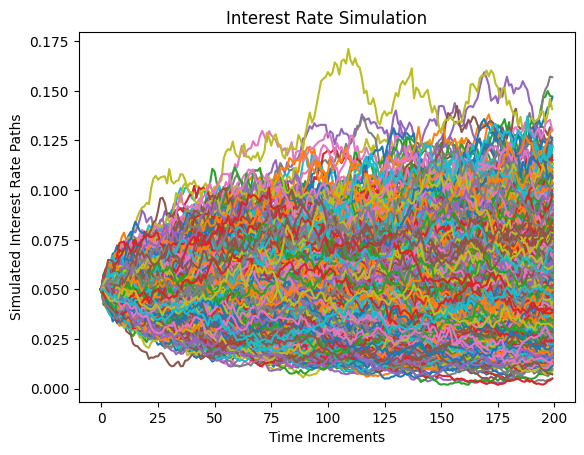

the simulated price of the ZCB is: 0.7844813979557798
the closed form solution price of the ZCB is: 0.9337109650810133
percent error: 15.982415619622248


In [28]:
# run monte carlo simulation

# compute paths
paths = ZCBpriceSim(r, rBar, a, sigma, bondMaturity, numberSimulations, steps, t)

# Plot the paths and setup titles
plt1.plot(paths.T)
plt1.xlabel("Time Increments")
plt1.ylabel("Simulated Interest Rate Paths")
plt1.title("Interest Rate Simulation")

plt1.show()


# Monte Carlo Simulation Price = average of all final values
simulationPrice = np.average(np.exp(-paths[:,-1]*(bondMaturity)))
print("the simulated price of the ZCB is:", simulationPrice)
print("the closed form solution price of the ZCB is:", closedFormCIR(r, rBar, a, sigma, t, bondMaturity))

# calculate percent error
percentError = ((closedFormCIR(r, rBar, a, sigma, t, bondMaturity) - simulationPrice)/(closedFormCIR(r, rBar, a, sigma, t, bondMaturity)))*100

print("percent error:", percentError)